In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, TFAutoModel, AutoTokenizer, BertTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2025-06-03 23:54:20.975622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = tf.data.Dataset.load(
    "dataset",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, ), dtype=tf.int32))
)

dataVal = tf.data.Dataset.load(
    "dataVal",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, ), dtype=tf.int32))
)

2025-06-03 23:54:27.024470: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 23:54:27.098927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 23:54:27.099001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 23:54:27.101864: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-03 23:54:27.101912: I external/local_xla/xla/stream_executor

In [ ]:
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.embedding_size = None
        self.bert = None

    def build(self, input_shape):
        self.bert = TFAutoModel.from_pretrained(self.model_name)
        self.embedding_size = self.bert.config.hidden_size
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        ids, att = inputs
        outputs = self.bert(input_ids=ids, attention_mask=att)
        return outputs.pooler_output

    def get_config(self):
        config = super(BertEmbeddingLayer, self).get_config()
        config.update({"model_name": self.model_name})
        return config

# Model stuff

## text only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50


I0000 00:00:1748955088.956768   15319 service.cc:145] XLA service 0x782bc4004ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748955088.956815   15319 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-06-03 19:51:29.686265: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1748955089.757131   15319 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748955089.859470   15319 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
2025-06-03 19:51:32.973217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1748955096.907344   15480 asm_compiler.cc:369] ptxas warning :

349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - binary_accuracy: 0.5289 - loss: 0.7586 - precision: 0.4654 - recall: 0.5481

W0000 00:00:1748955132.802354   15317 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748955132.807769   15317 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748955137.555076   15553 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1748955137.725337   15558 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1748955137.920183   15551 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 264 bytes spill stores, 264 bytes spill loads

I0000 00:00:1748955137.926110   15549 asm_compiler.cc:369] ptxas warning : Registers are spilled t

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - binary_accuracy: 0.5289 - loss: 0.7585 - precision: 0.4654 - recall: 0.5479

W0000 00:00:1748955146.749375   15313 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748955146.838405   15313 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748955148.410474   15800 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_11570', 8 bytes spill stores, 8 bytes spill loads

W0000 00:00:1748955158.216203   15313 assert_op.cc:38] Ignoring Assert operator functional_1/indobert1_1/tf_bert_model/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748955158.221205   15313 assert_op.cc:38] Ignoring Assert operator functional_1/indobert2_1/tf_bert_model_1/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748955159.914249   15877 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2', 12 bytes spil

350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 176ms/step - binary_accuracy: 0.5290 - loss: 0.7584 - precision: 0.4655 - recall: 0.5478 - val_binary_accuracy: 0.5956 - val_loss: 0.6617 - val_precision: 0.7287 - val_recall: 0.0791 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - binary_accuracy: 0.6067 - loss: 0.6802 - precision: 0.5542 - recall: 0.4735 - val_binary_accuracy: 0.6764 - val_loss: 0.6041 - val_precision: 0.6834 - val_recall: 0.4466 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - binary_accuracy: 0.6372 - loss: 0.6477 - precision: 0.5965 - recall: 0.5026 - val_binary_accuracy: 0.6990 - val_loss: 0.5813 - val_precision: 0.6921 - val_recall: 0.5273 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - binary_accuracy: 0.6690 - loss: 0.6178 - precision: 0.6383 - recall: 0.5452 - val_binary_accuracy: 0.7069 - val_loss: 0.5673 - val_precision: 0.6947 - val_recall: 0.5551 - learning_rate: 5.

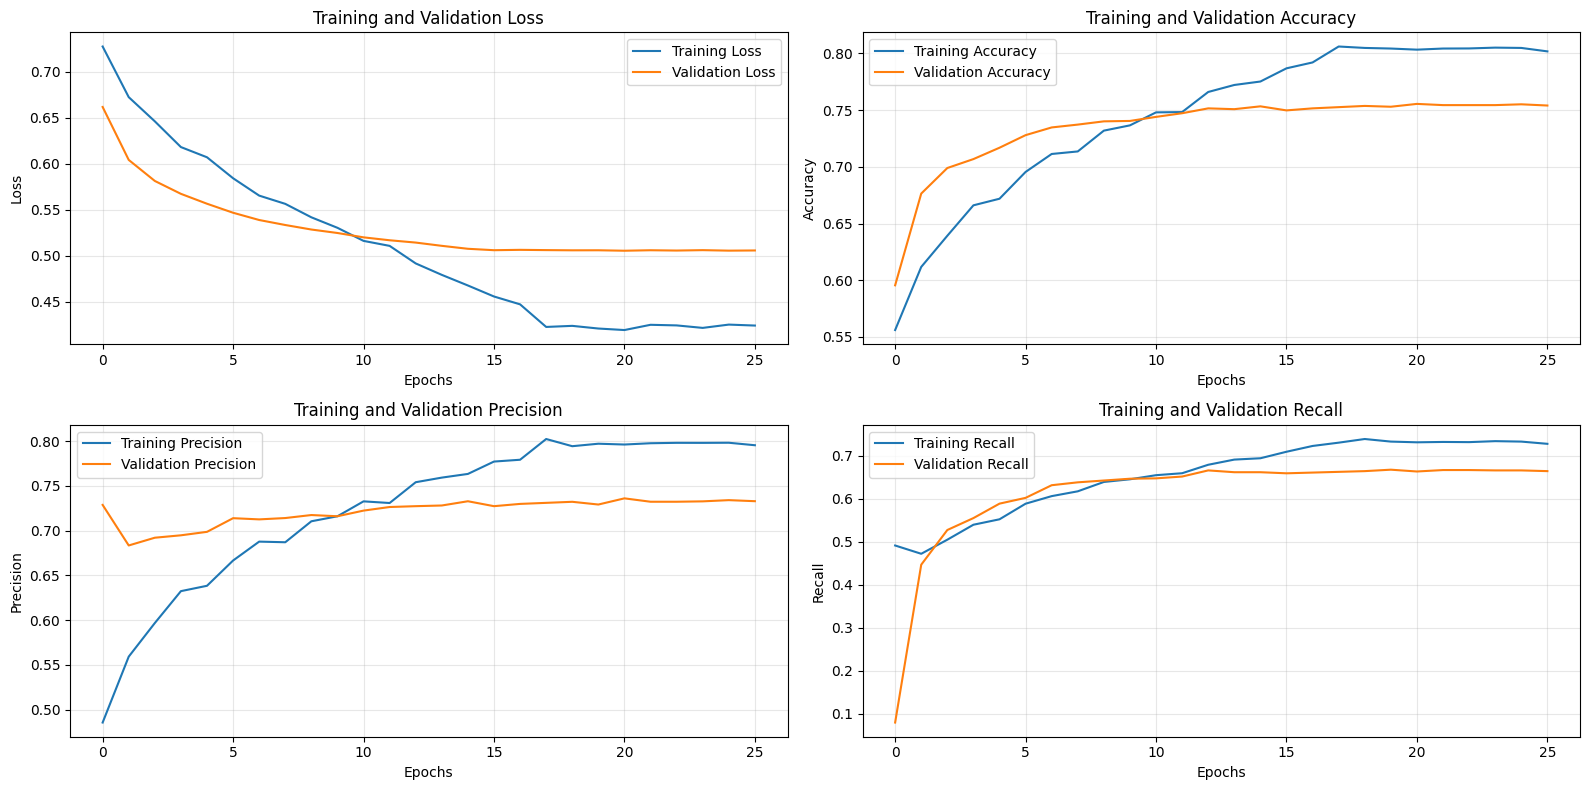


FINAL METRICS SUMMARY
Loss           : Train = 0.4242, Val = 0.5058
Binary_accuracy: Train = 0.8019, Val = 0.7541
Precision      : Train = 0.7953, Val = 0.7328
Recall         : Train = 0.7280, Val = 0.6644


In [ ]:
def makemodel(output_bias=None):
    # Text using IndoBertp1
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    fin = tf.keras.layers.concatenate([title, content])
    
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

textOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/text_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=textOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## title & image

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 220s 479ms/step - binary_accuracy: 0.5043 - loss: 0.7792 - precision: 0.4493 - recall: 0.6233 - val_binary_accuracy: 0.6156 - val_loss: 0.6610 - val_precision: 0.5941 - val_recall: 0.3053 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 160s 458ms/step - binary_accuracy: 0.5779 - loss: 0.6986 - precision: 0.5156 - recall: 0.4308 - val_binary_accuracy: 0.6467 - val_loss: 0.6337 - val_precision: 0.6269 - val_recall: 0.4197 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - binary_accuracy: 0.6085 - loss: 0.6674 - precision: 0.5589 - recall: 0.4603 - val_binary_accuracy: 0.6618 - val_loss: 0.6199 - val_precision: 0.6374 - val_recall: 0.4760 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 161s 459ms/step - binary_accuracy: 0.6412 - loss: 0.6431 - precision: 0.6063 - recall: 0.4913 - val_binary_accuracy: 0.6764 - val_loss: 0.6087 - val_precision: 0.6607 - val_recall: 0.4929 - le

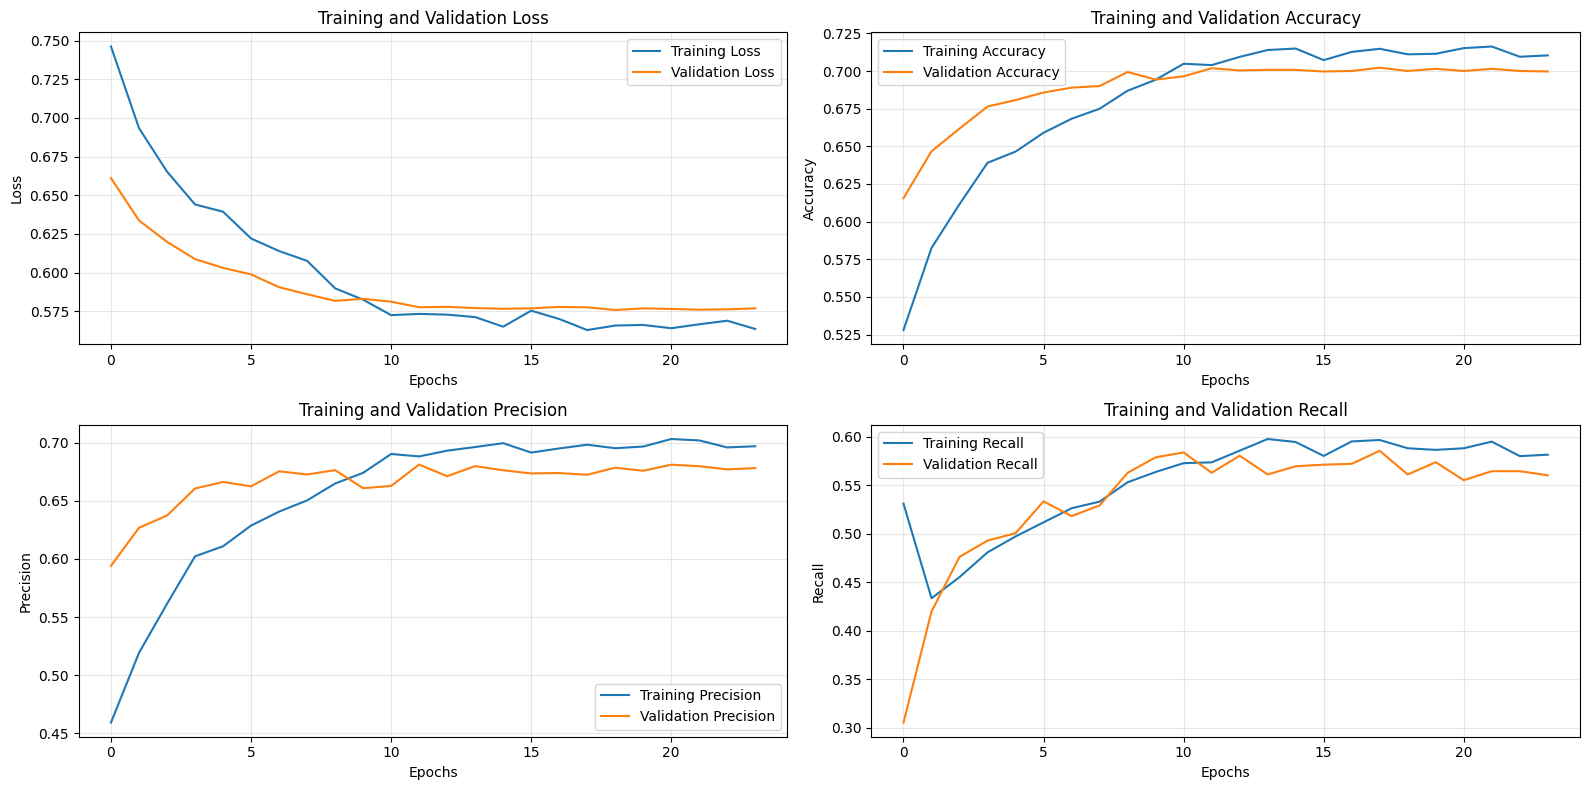


FINAL METRICS SUMMARY
Loss           : Train = 0.5635, Val = 0.5769
Binary_accuracy: Train = 0.7104, Val = 0.6997
Precision      : Train = 0.6970, Val = 0.6782
Recall         : Train = 0.5813, Val = 0.5601


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")

    title = indobert1([ids1, att1])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

titleImage = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/title_image_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleImage.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## content & image

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 160s 458ms/step - binary_accuracy: 0.7070 - loss: 0.5720 - precision: 0.6904 - recall: 0.5870 - val_binary_accuracy: 0.6990 - val_loss: 0.5766 - val_precision: 0.6747 - val_recall: 0.5652 - learning_rate: 1.0000e-08
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 158s 452ms/step - binary_accuracy: 0.7155 - loss: 0.5673 - precision: 0.7040 - recall: 0.5930 - val_binary_accuracy: 0.7008 - val_loss: 0.5766 - val_precision: 0.6799 - val_recall: 0.5610 - learning_rate: 1.0000e-08
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 160s 458ms/step - binary_accuracy: 0.7079 - loss: 0.5656 - precision: 0.6912 - recall: 0.5893 - val_binary_accuracy: 0.7037 - val_loss: 0.5763 - val_precision: 0.6789 - val_recall: 0.5761 - learning_rate: 1.0000e-08
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 159s 454ms/step - binary_accuracy: 0.7110 - loss: 0.5649 - precision: 0.7005 - recall: 0.5824 - val_binary_accuracy: 0.7029 - val_loss: 0.5770 - val_precision: 0.6779 - val_recall: 0.5753 - le

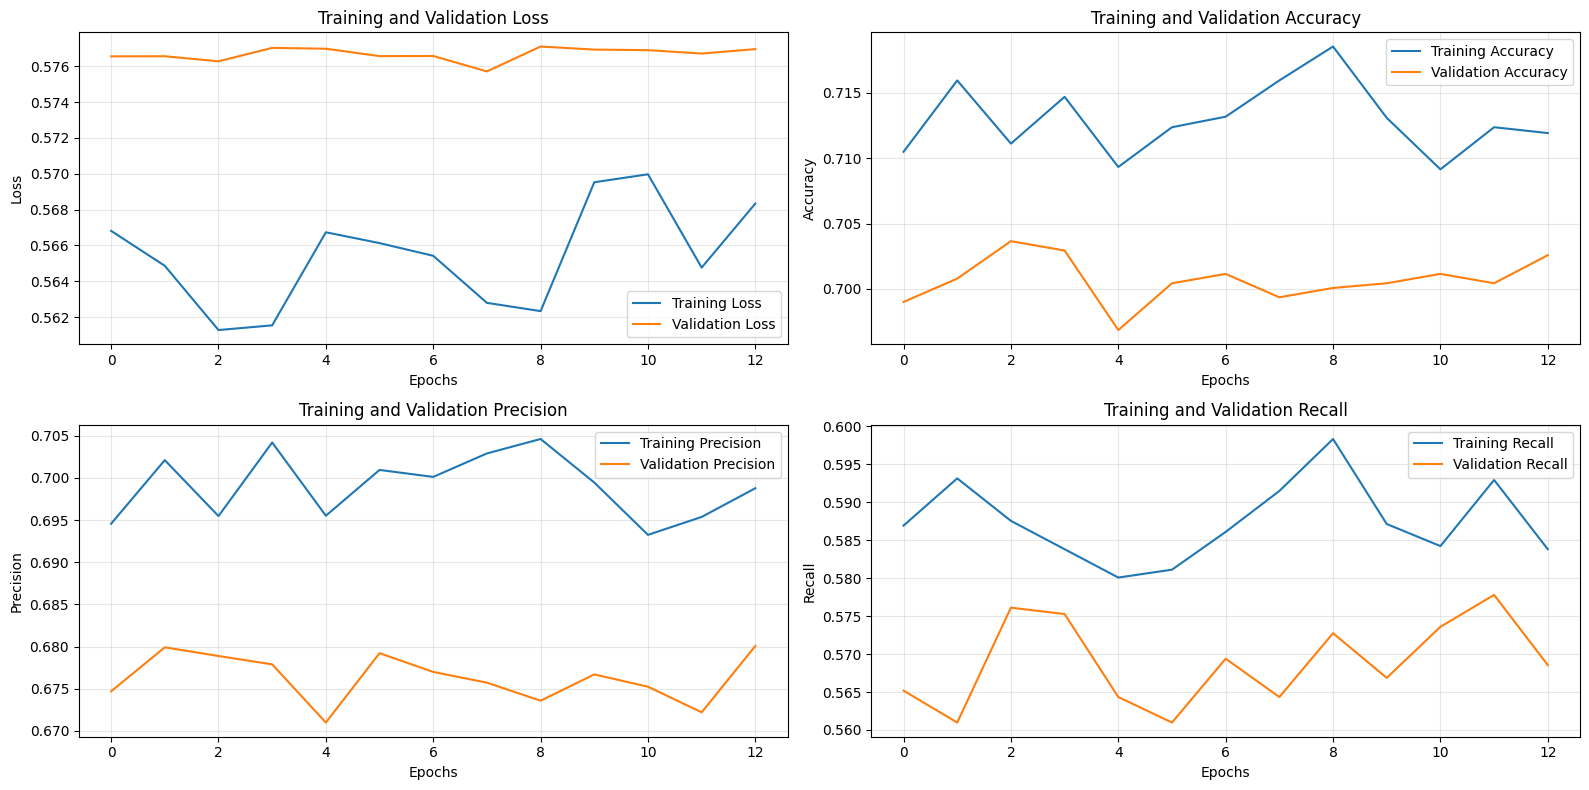


FINAL METRICS SUMMARY
Loss           : Train = 0.5683, Val = 0.5770
Binary_accuracy: Train = 0.7119, Val = 0.7026
Precision      : Train = 0.6988, Val = 0.6801
Recall         : Train = 0.5838, Val = 0.5685


In [ ]:
def makemodel(output_bias=None):
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

contentImage = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/content_image_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleImage.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## title only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50


W0000 00:00:1748962086.072423   15297 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert1_1/tf_bert_model_4/bert/embeddings/assert_less/Assert/Assert


347/350 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - binary_accuracy: 0.5309 - loss: 0.7519 - precision: 0.4589 - recall: 0.4549

W0000 00:00:1748962102.402641   15304 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert1_1/tf_bert_model_4/bert/embeddings/assert_less/Assert/Assert


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.5310 - loss: 0.7518 - precision: 0.4590 - recall: 0.4548

W0000 00:00:1748962111.039927   15302 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert1_1/tf_bert_model_4/bert/embeddings/assert_less/Assert/Assert
I0000 00:00:1748962112.249737   33108 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5843', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1748962112.471117   33116 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5843', 24 bytes spill stores, 24 bytes spill loads

W0000 00:00:1748962115.895789   15304 assert_op.cc:38] Ignoring Assert operator functional_3_1/indobert1_1/tf_bert_model_4/bert/embeddings/assert_less/Assert/Assert


350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - binary_accuracy: 0.5310 - loss: 0.7518 - precision: 0.4590 - recall: 0.4547 - val_binary_accuracy: 0.4814 - val_loss: 0.6961 - val_precision: 0.4471 - val_recall: 0.9235 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - binary_accuracy: 0.5743 - loss: 0.7139 - precision: 0.5105 - recall: 0.4347 - val_binary_accuracy: 0.6382 - val_loss: 0.6473 - val_precision: 0.5689 - val_recall: 0.6182 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - binary_accuracy: 0.6157 - loss: 0.6704 - precision: 0.5673 - recall: 0.4769 - val_binary_accuracy: 0.6546 - val_loss: 0.6347 - val_precision: 0.5938 - val_recall: 0.5963 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - binary_accuracy: 0.6240 - loss: 0.6601 - precision: 0.5774 - recall: 0.4941 - val_binary_accuracy: 0.6618 - val_loss: 0.6278 - val_precision: 0.5992 - val_recall: 0.6198 - learning_rate: 5.0000e-

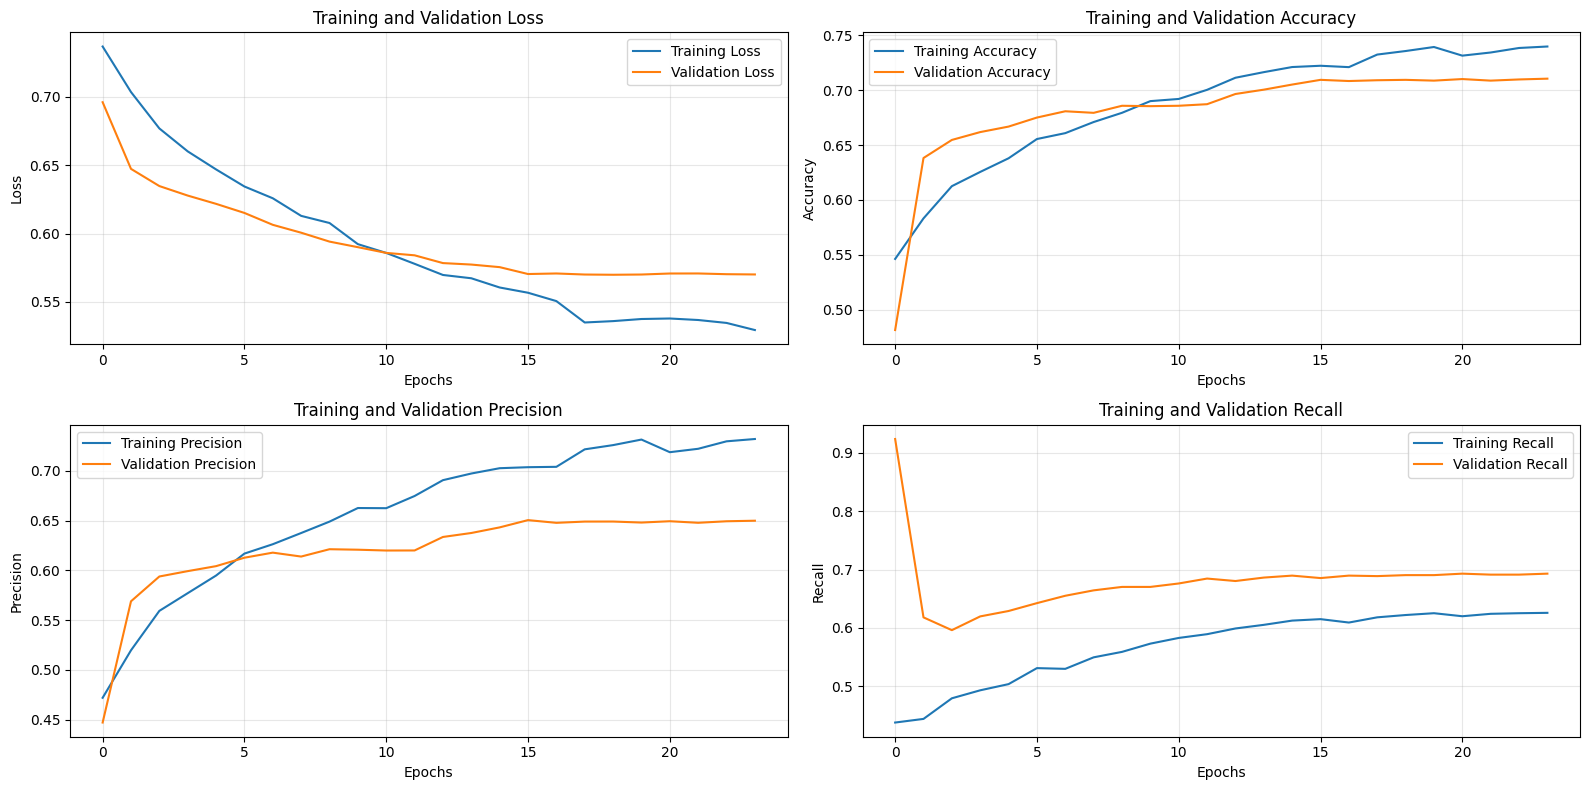


FINAL METRICS SUMMARY
Loss           : Train = 0.5294, Val = 0.5701
Binary_accuracy: Train = 0.7398, Val = 0.7105
Precision      : Train = 0.7319, Val = 0.6498
Recall         : Train = 0.6259, Val = 0.6930


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")

    title = indobert1([ids1, att1])
    
    fin = tf.keras.layers.BatchNormalization()(title)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

titleOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/title_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=titleOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## content only

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50


W0000 00:00:1748962337.759786   15306 assert_op.cc:38] Ignoring Assert operator functional_4_1/indobert2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - binary_accuracy: 0.4971 - loss: 0.7939 - precision: 0.4368 - recall: 0.5348

W0000 00:00:1748962369.683621   15306 assert_op.cc:38] Ignoring Assert operator functional_4_1/indobert2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - binary_accuracy: 0.4972 - loss: 0.7938 - precision: 0.4369 - recall: 0.5346

W0000 00:00:1748962379.419408   15304 assert_op.cc:38] Ignoring Assert operator functional_4_1/indobert2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1748962386.860562   15302 assert_op.cc:38] Ignoring Assert operator functional_4_1/indobert2_1/tf_bert_model_5/bert/embeddings/assert_less/Assert/Assert


350/350 ━━━━━━━━━━━━━━━━━━━━ 60s 121ms/step - binary_accuracy: 0.4973 - loss: 0.7937 - precision: 0.4369 - recall: 0.5345 - val_binary_accuracy: 0.5784 - val_loss: 0.6710 - val_precision: 0.6774 - val_recall: 0.0177 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - binary_accuracy: 0.5645 - loss: 0.7161 - precision: 0.4968 - recall: 0.4219 - val_binary_accuracy: 0.6417 - val_loss: 0.6385 - val_precision: 0.6093 - val_recall: 0.4407 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - binary_accuracy: 0.6002 - loss: 0.6819 - precision: 0.5471 - recall: 0.4521 - val_binary_accuracy: 0.6539 - val_loss: 0.6265 - val_precision: 0.6082 - val_recall: 0.5248 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - binary_accuracy: 0.6083 - loss: 0.6767 - precision: 0.5572 - recall: 0.4684 - val_binary_accuracy: 0.6603 - val_loss: 0.6216 - val_precision: 0.6095 - val_recall: 0.5618 - learning_rate: 5.000

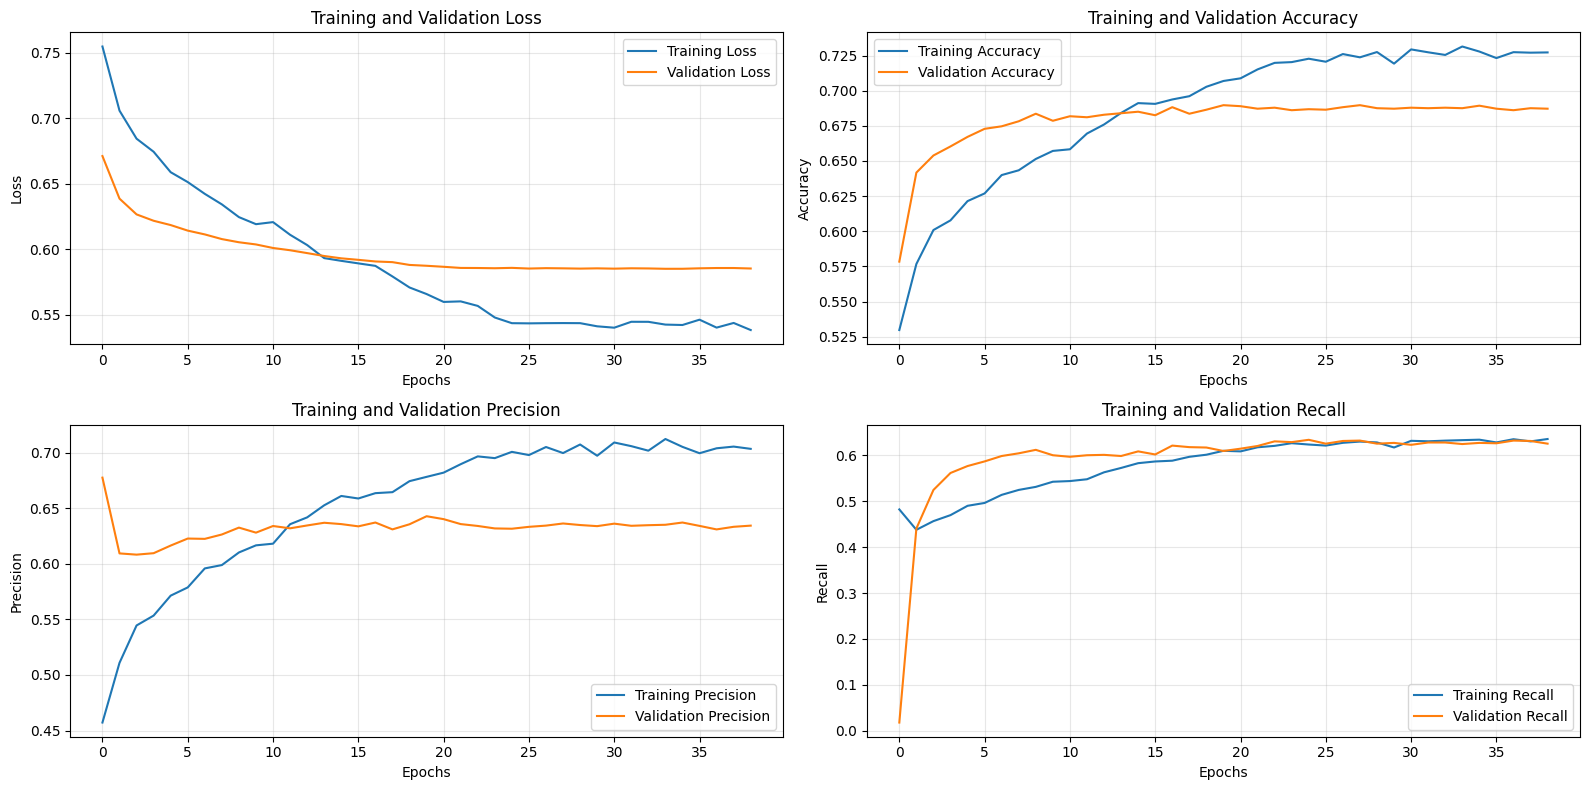


FINAL METRICS SUMMARY
Loss           : Train = 0.5383, Val = 0.5852
Binary_accuracy: Train = 0.7272, Val = 0.6872
Precision      : Train = 0.7033, Val = 0.6343
Recall         : Train = 0.6359, Val = 0.6257


In [ ]:
def makemodel(output_bias=None):
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    content = indobert2([ids2, att2])

    fin = tf.keras.layers.BatchNormalization()(content)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids2, att2], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

contentOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/content_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=contentOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## img only

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 183s 405ms/step - binary_accuracy: 0.5540 - loss: 0.8100 - precision: 0.4616 - recall: 0.1756 - val_binary_accuracy: 0.5673 - val_loss: 0.6755 - val_precision: 0.4911 - val_recall: 0.4659 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 137s 392ms/step - binary_accuracy: 0.5483 - loss: 0.7229 - precision: 0.4731 - recall: 0.3729 - val_binary_accuracy: 0.5999 - val_loss: 0.6651 - val_precision: 0.5336 - val_recall: 0.4735 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 397ms/step - binary_accuracy: 0.5478 - loss: 0.7258 - precision: 0.4724 - recall: 0.3741 - val_binary_accuracy: 0.6049 - val_loss: 0.6624 - val_precision: 0.5415 - val_recall: 0.4668 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 398ms/step - binary_accuracy: 0.5786 - loss: 0.6979 - precision: 0.5177 - recall: 0.4043 - val_binary_accuracy: 0.6127 - val_loss: 0.6599 - val_precision: 0.5520 - val_recall: 0.4777 - le

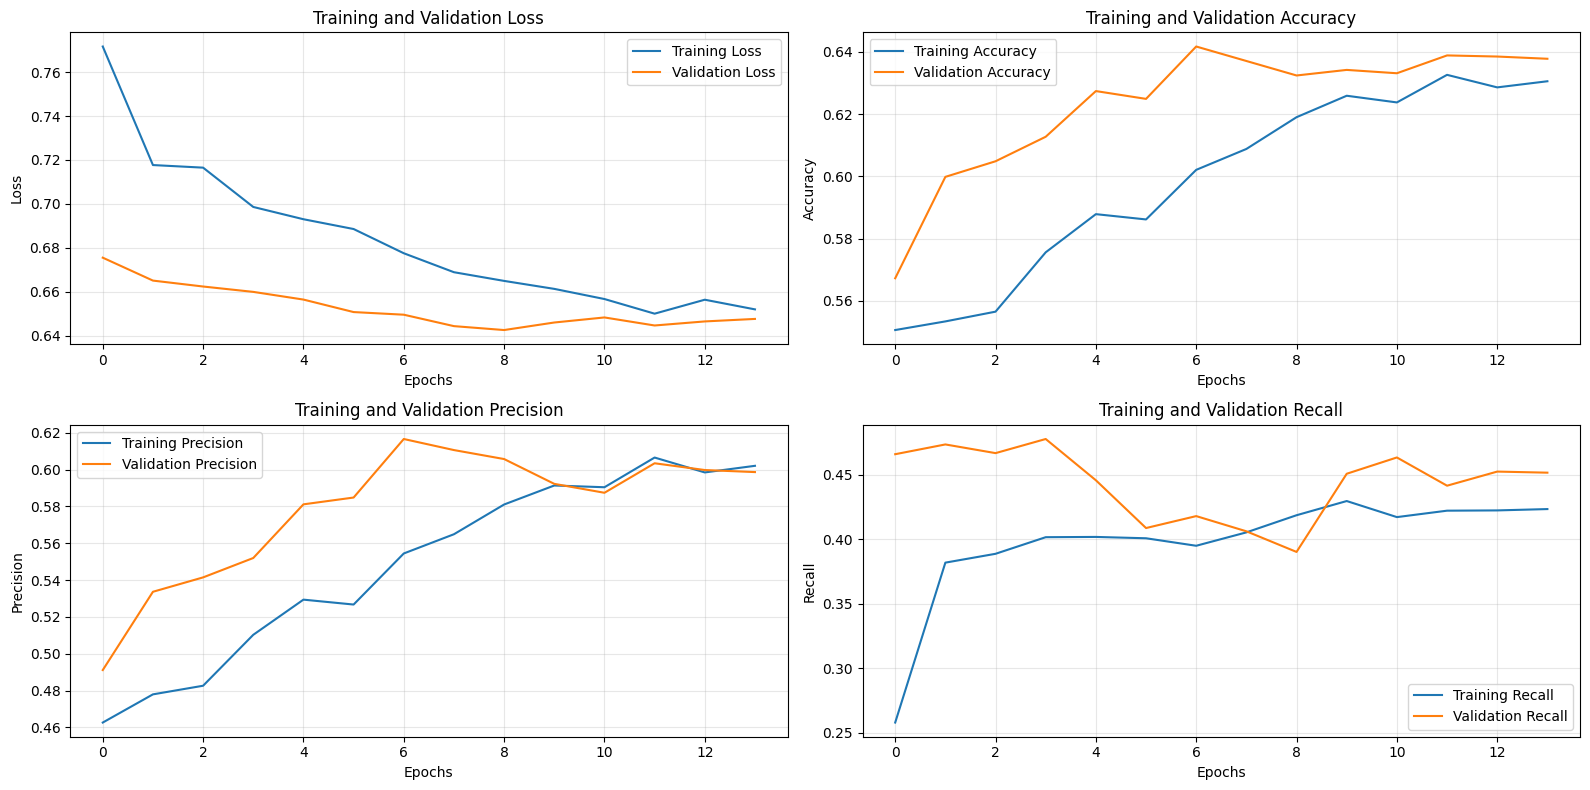


FINAL METRICS SUMMARY
Loss           : Train = 0.6520, Val = 0.6476
Binary_accuracy: Train = 0.6306, Val = 0.6378
Precision      : Train = 0.6021, Val = 0.5987
Recall         : Train = 0.4234, Val = 0.4516


In [ ]:
def makemodel(output_bias=None):
    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.BatchNormalization()(image)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

imageOnly = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/image_only_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=imageOnly.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )

print(history.history.keys())


final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## gabung teks ke indobert yang sama

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/pooler/dense/bias:0', 'bert/encoder/layer_._6/output/dense/kernel:0', 'bert/encoder/layer_._3/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/self/key/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._9/attention/self/query/kernel:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._7/attention/self/query/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/kernel:0', 'bert/encoder/layer_._0/attention/output/dense/kernel:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._9/output/dense/bias:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/gamma:0', 'bert/encoder/layer_._0/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._5/intermediate/dense/kernel:0', 'bert/encoder/lay

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 266s 605ms/step - binary_accuracy: 0.5486 - loss: 0.7715 - precision: 0.4662 - recall: 0.3068 - val_binary_accuracy: 0.6342 - val_loss: 0.6529 - val_precision: 0.5986 - val_recall: 0.4264 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - binary_accuracy: 0.6002 - loss: 0.6835 - precision: 0.5463 - recall: 0.4575 - val_binary_accuracy: 0.6764 - val_loss: 0.6121 - val_precision: 0.6177 - val_recall: 0.6291 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 207s 591ms/step - binary_accuracy: 0.6305 - loss: 0.6502 - precision: 0.5858 - recall: 0.5057 - val_binary_accuracy: 0.6915 - val_loss: 0.5968 - val_precision: 0.6276 - val_recall: 0.6762 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 206s 588ms/step - binary_accuracy: 0.6488 - loss: 0.6395 - precision: 0.6071 - recall: 0.5375 - val_binary_accuracy: 0.6911 - val_loss: 0.5922 - val_precision: 0.6220 - val_recall: 0.6989 - le

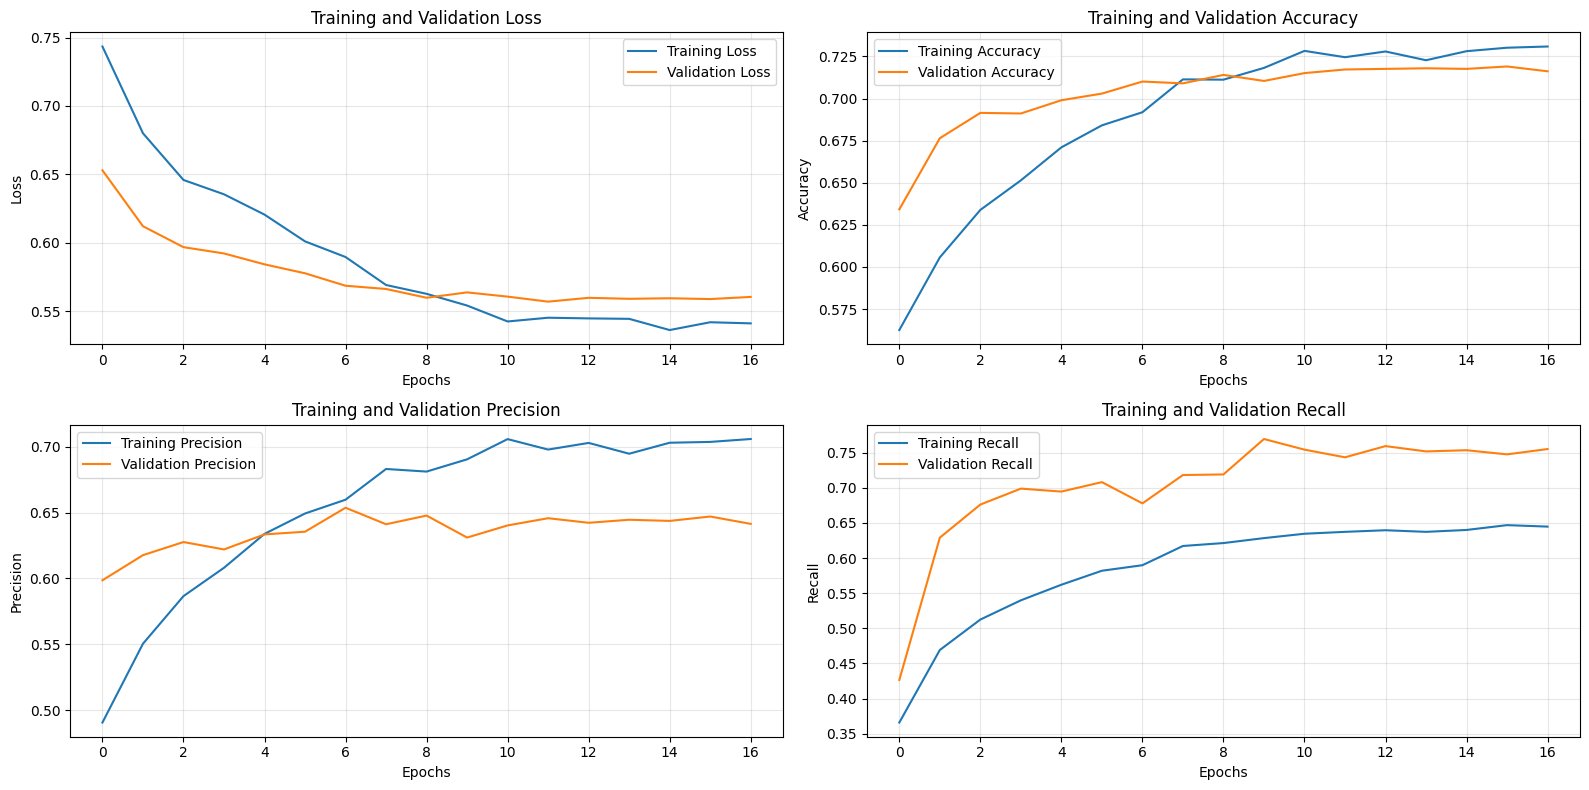


FINAL METRICS SUMMARY
Loss           : Train = 0.5411, Val = 0.5604
Binary_accuracy: Train = 0.7309, Val = 0.7162
Precision      : Train = 0.7059, Val = 0.6414
Recall         : Train = 0.6448, Val = 0.7553


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert")

    title = indobert([ids1, att1])
    content = indobert([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

oneBert = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/one_bert_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=oneBert.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## without batch normalizing

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._4/output/dense/kernel:0', 'bert/encoder/layer_._7/output/dense/bias:0', 'bert/encoder/layer_._6/attention/self/value/kernel:0', 'bert/encoder/layer_._11/attention/self/key/kernel:0', 'bert/encoder/layer_._3/output/LayerNorm/beta:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._7/output/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/query/bias:0', 'bert/encoder/layer_._10/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._0/attention/self/query/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._7/attention/output/dense/bias:0', 'bert/encoder/layer_._1/intermediate/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/value/kernel:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50


2025-06-03 23:55:31.001410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetv2-b0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-03 23:55:36.028442: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


350/350 ━━━━━━━━━━━━━━━━━━━━ 253s 577ms/step - binary_accuracy: 0.5271 - loss: 1.0799 - precision: 0.4522 - recall: 0.4357 - val_binary_accuracy: 0.5770 - val_loss: 0.6795 - val_precision: 0.5085 - val_recall: 0.1766 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 192s 550ms/step - binary_accuracy: 0.5273 - loss: 0.7320 - precision: 0.4428 - recall: 0.3506 - val_binary_accuracy: 0.5845 - val_loss: 0.6769 - val_precision: 0.5303 - val_recall: 0.2061 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 194s 555ms/step - binary_accuracy: 0.5378 - loss: 0.7066 - precision: 0.4553 - recall: 0.3372 - val_binary_accuracy: 0.6074 - val_loss: 0.6724 - val_precision: 0.6055 - val_recall: 0.2220 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 193s 551ms/step - binary_accuracy: 0.5652 - loss: 0.6890 - precision: 0.4969 - recall: 0.3212 - val_binary_accuracy: 0.6152 - val_loss: 0.6689 - val_precision: 0.6404 - val_recall: 0.2187 - learning_rate

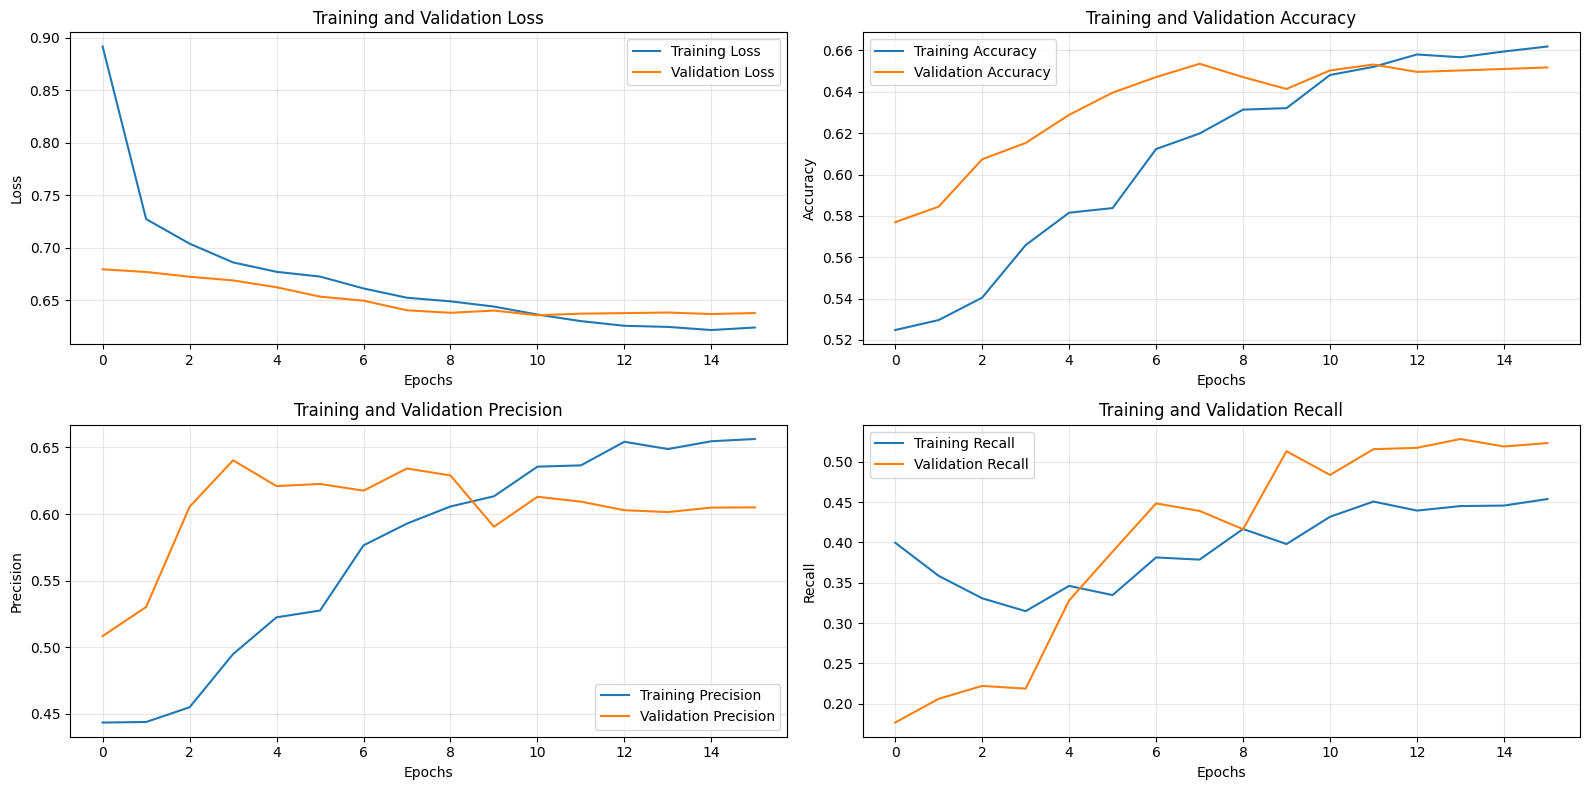


FINAL METRICS SUMMARY
Loss           : Train = 0.6241, Val = 0.6378
Binary_accuracy: Train = 0.6619, Val = 0.6518
Precision      : Train = 0.6564, Val = 0.6051
Recall         : Train = 0.4537, Val = 0.5231


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert")

    title = indobert([ids1, att1])
    content = indobert([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

noNorm = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/no_norm_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=noNorm.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

## Jumlah dense layer

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._4/output/dense/kernel:0', 'bert/encoder/layer_._7/output/dense/bias:0', 'bert/encoder/layer_._6/attention/self/value/kernel:0', 'bert/encoder/layer_._11/attention/self/key/kernel:0', 'bert/encoder/layer_._3/output/LayerNorm/beta:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._7/output/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/query/bias:0', 'bert/encoder/layer_._10/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._0/attention/self/query/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._7/attention/output/dense/bias:0', 'bert/encoder/layer_._1/intermediate/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/value/kernel:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 272s 617ms/step - binary_accuracy: 0.5361 - loss: 0.7440 - precision: 0.4520 - recall: 0.3379 - val_binary_accuracy: 0.6059 - val_loss: 0.6679 - val_precision: 0.5595 - val_recall: 0.3482 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 208s 594ms/step - binary_accuracy: 0.5802 - loss: 0.6940 - precision: 0.5197 - recall: 0.4085 - val_binary_accuracy: 0.6779 - val_loss: 0.6175 - val_precision: 0.6476 - val_recall: 0.5332 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 208s 593ms/step - binary_accuracy: 0.6203 - loss: 0.6584 - precision: 0.5738 - recall: 0.4794 - val_binary_accuracy: 0.6904 - val_loss: 0.5919 - val_precision: 0.6598 - val_recall: 0.5627 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 208s 594ms/step - binary_accuracy: 0.6390 - loss: 0.6407 - precision: 0.6017 - recall: 0.4938 - val_binary_accuracy: 0.7004 - val_loss: 0.5777 - val_precision: 0.6683 - val_recall: 0.5879 - le

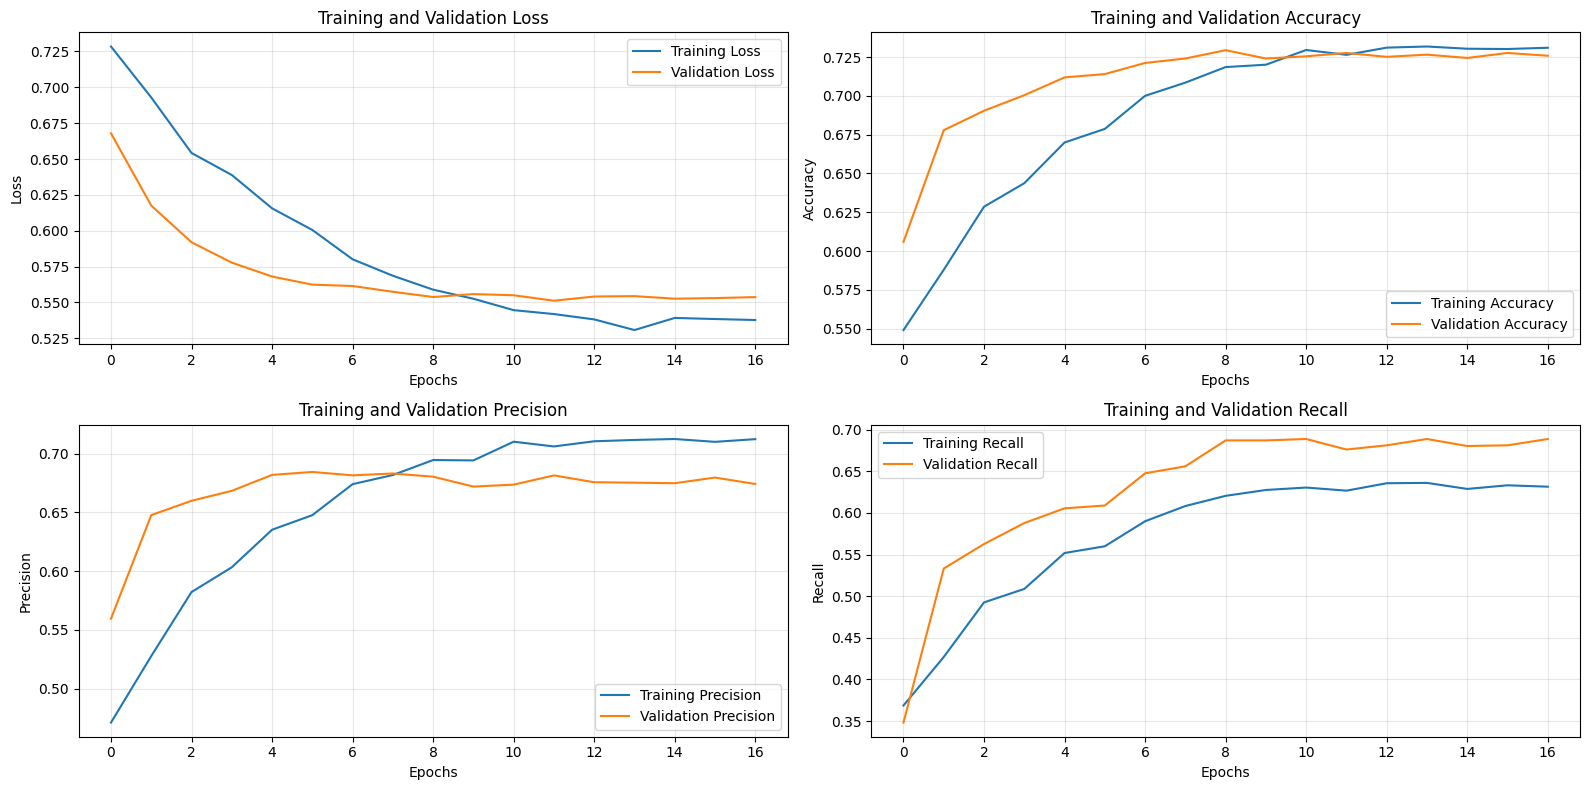


FINAL METRICS SUMMARY
Loss           : Train = 0.5378, Val = 0.5537
Binary_accuracy: Train = 0.7310, Val = 0.7258
Precision      : Train = 0.7122, Val = 0.6741
Recall         : Train = 0.6315, Val = 0.6888


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)
        
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 
    
    fin = tf.keras.layers.Dense(512, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.4)(fin) 

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

moreDense = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/more_dense_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=moreDense.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls', 'bert/encoder/layer_._4/output/dense/kernel:0', 'bert/encoder/layer_._7/output/dense/bias:0', 'bert/encoder/layer_._6/attention/self/value/kernel:0', 'bert/encoder/layer_._11/attention/self/key/kernel:0', 'bert/encoder/layer_._3/output/LayerNorm/beta:0', 'bert/encoder/layer_._4/attention/self/value/bias:0', 'bert/encoder/layer_._7/output/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/query/bias:0', 'bert/encoder/layer_._10/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._8/attention/self/query/kernel:0', 'bert/encoder/layer_._0/attention/self/query/bias:0', 'bert/encoder/layer_._4/attention/self/value/kernel:0', 'bert/encoder/layer_._7/attention/output/dense/bias:0', 'bert/encoder/layer_._1/intermediate/dense/kernel:0', 'bert/encoder/layer_._9/attention/self/value/kernel:0', 'bert/encoder/layer_._10/output/dense/bias:0', 'bert

Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 269s 612ms/step - binary_accuracy: 0.5659 - loss: 0.7254 - precision: 0.4980 - recall: 0.3950 - val_binary_accuracy: 0.6324 - val_loss: 0.6478 - val_precision: 0.5683 - val_recall: 0.5669 - learning_rate: 5.0000e-05
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 209s 597ms/step - binary_accuracy: 0.6407 - loss: 0.6467 - precision: 0.5999 - recall: 0.5147 - val_binary_accuracy: 0.6790 - val_loss: 0.5968 - val_precision: 0.6274 - val_recall: 0.6047 - learning_rate: 5.0000e-05
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 209s 596ms/step - binary_accuracy: 0.6757 - loss: 0.6108 - precision: 0.6465 - recall: 0.5555 - val_binary_accuracy: 0.7065 - val_loss: 0.5714 - val_precision: 0.6661 - val_recall: 0.6224 - learning_rate: 5.0000e-05
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 209s 598ms/step - binary_accuracy: 0.6898 - loss: 0.5932 - precision: 0.6623 - recall: 0.5796 - val_binary_accuracy: 0.7137 - val_loss: 0.5650 - val_precision: 0.6636 - val_recall: 0.6636 - le

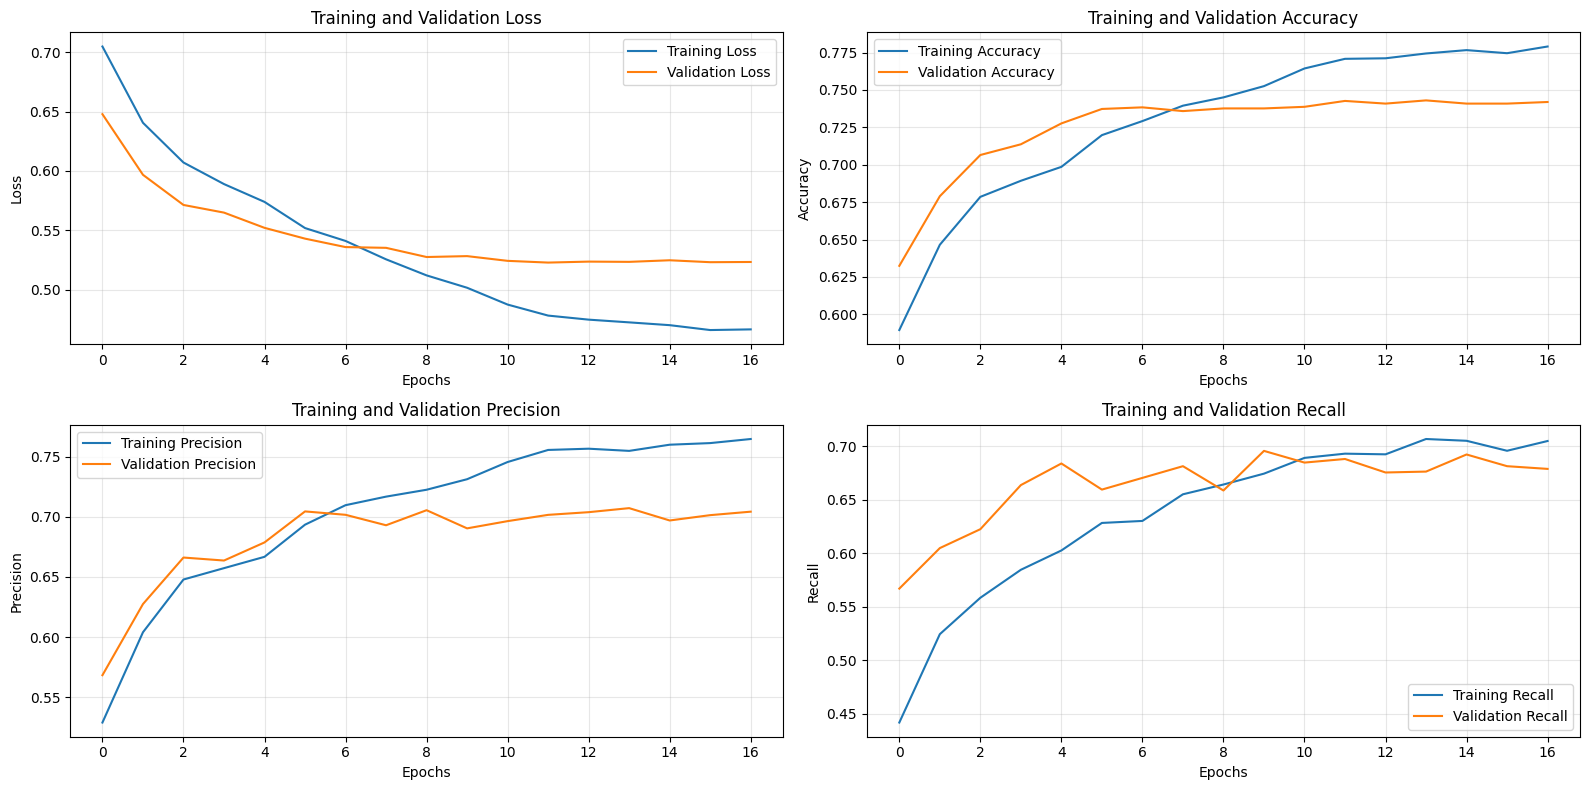


FINAL METRICS SUMMARY
Loss           : Train = 0.4667, Val = 0.5234
Binary_accuracy: Train = 0.7790, Val = 0.7419
Precision      : Train = 0.7646, Val = 0.7042
Recall         : Train = 0.7048, Val = 0.6787


In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(224,224,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224,224,3),
        pooling = 'max'
    )
    image = effi(img_aug)

    fin = tf.keras.layers.concatenate([title, content, image])
    fin = tf.keras.layers.BatchNormalization()(fin)

    fin = tf.keras.layers.Dense(256, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(128, activation=None)(fin)
    fin = tf.keras.layers.BatchNormalization()(fin)
    fin = tf.keras.layers.Activation('relu')(fin)
    fin = tf.keras.layers.Dropout(0.3)(fin) 
    
    fin = tf.keras.layers.Dense(64, activation='relu')(fin)
    fin = tf.keras.layers.Dropout(0.2)(fin)
    fin = tf.keras.layers.Dense(1, activation='sigmoid')(fin)

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
    )

    return final

lessDense = makemodel()
tf.keras.mixed_precision.set_global_policy('mixed_float16')

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
    )

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./models/less_dense_val_loss_{val_loss:.4f}.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=1e-8
)

history=lessDense.fit(x = dataset,
                  epochs = 50,
                  callbacks=[early_stopping, model_checkpoint, reduce_lr],
                  validation_data=dataVal
                  )
print(history.history.keys())

final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()